In [ ]:
# Problem Statement

### Identify which questions asked on Quora are duplicates of questions that have already been asked.

# Methodology Used - Crisp DM
CRISP-DM, which stands for Cross-Industry Standard Process for Data Mining, is an industry-proven way to guide your data mining efforts. As a methodology, it includes descriptions of the typical phases of a project, the tasks involved with each phase, and an explanation of the relationships between these tasks.

## Data Loading as Pandas Dataframe

The data, Quora Question Pairs, contains a human-labeled training set and a test set. Each record in the training set contains a pair of questions as well as a binary label indicating whether or not the record is a duplicate.

### Importing Libraries

In [1]:
#!pip install xgboost --user
#!pip install nltk --user
#!pip install gensim --user
#!pip install pyemd --user
#!pip install -U scikit-learn --user
# !pip install fuzzywuzzy --user
# !pip install python-Levenshtein --user

In [2]:
import pandas as pd
import numpy as np
from fuzzywuzzy import fuzz
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from copy import deepcopy
from sklearn.decomposition import TruncatedSVD
from scipy import sparse
import gensim
import gensim.downloader as api
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import word_tokenize
from scipy.spatial.distance import cosine, cityblock, jaccard, canberra, euclidean, minkowski, braycurtis
from gensim.parsing.preprocessing import preprocess_string, strip_tags, strip_multiple_whitespaces, remove_stopwords, stem_text
import gc
import psutil
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import zipfile
from tqdm import tqdm_notebook as tqdm
import tensorflow as tf
print("TensorFlow version %s" % tf.__version__)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mishr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mishr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


TensorFlow version 2.8.0


### Reading train.csv from Storage

In [3]:
df = pd.read_csv('train.csv')
df = df.drop(['id', 'qid1', 'qid2'], axis=1)
df.head(5)

,question1,question2,is_duplicate
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


### Creating basic features for these question attributes for pre-processing
As we need to identify some relation between these two attributes for classification and EDA

### Function to return length difference between two text attributes

In [4]:
def LengthDiff(df,a,b):
    df['len_q1'] = df[a].apply(lambda x: len(str(x)))
    df['len_q2'] = df[b].apply(lambda x: len(str(x)))
    # difference in lengths of two questions
    return df.len_q1 - df.len_q2

df['diff_len'] = LengthDiff(df,'question1','question2')
df.head(5)

,question1,question2,is_duplicate,len_q1,len_q2,diff_len
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,9
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,-37
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,14
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65,-15
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39,37


### Function to return character length difference between two text attributes

In [5]:
def CharLengthDiff(df,a,b):
    df['len_char_q1'] = df[a].apply(lambda x: len(''.join(set(str(x).replace(' ', '')))))
    df['len_char_q2'] = df[b].apply(lambda x: len(''.join(set(str(x).replace(' ', '')))))
    return df
df = CharLengthDiff(df,'question1','question2')
df.head(5)

,question1,question2,is_duplicate,len_q1,len_q2,diff_len,len_char_q1,len_char_q2
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,9,20,20
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,-37,21,29
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,14,25,24
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65,-15,19,26
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39,37,25,18


### Function to return word  length difference between two text attributes

In [6]:
def WordLengthDiff(df,a,b):
    df['len_word_q1'] = df[a].apply(lambda x: len(str(x).split()))
    df['len_word_q2'] = df[a].apply(lambda x: len(str(x).split()))
    return df
df = WordLengthDiff(df,'question1','question2')
df.head(5)

,question1,question2,is_duplicate,len_q1,len_q2,diff_len,len_char_q1,len_char_q2,len_word_q1,len_word_q2
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,9,20,20,14,14
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,-37,21,29,8,8
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,14,25,24,14,14
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65,-15,19,26,11,11
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39,37,25,18,13,13


### Function to return Common words between two text attributes

In [7]:
def CommonWord(df,a,b):
    df['common_words'] = df.apply(lambda x: len(set(str(x[a]).lower().split()).intersection(set(str(x[b]).lower().split()))), axis=1)
    return df
df = CommonWord(df,'question1','question2')
df.head(5)

,question1,question2,is_duplicate,len_q1,len_q2,diff_len,len_char_q1,len_char_q2,len_word_q1,len_word_q2,common_words
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,9,20,20,14,14,10
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,-37,21,29,8,8,4
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,14,25,24,14,14,4
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65,-15,19,26,11,11,0
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39,37,25,18,13,13,2


In [8]:
fs_1 = ['len_q1', 'len_q2', 'diff_len', 'len_char_q1', 
        'len_char_q2', 'len_word_q1', 'len_word_q2',     
        'common_words']

## EDA

### Count Plot of is_duplicate Attribute

In [9]:
def CountPlot(df,col,l=15,b=5,yaxis = ''):
    figure, ax = plt.subplots(figsize=(l, b))
    # count plot on single categorical variable
    sns.countplot(x =col, data = df)
    plt.title('Total count of each category in '+col+' column')
    plt.ylabel('Number of ' + yaxis)
    plt.show()

0    255027
1    149263
Name: is_duplicate, dtype: int64


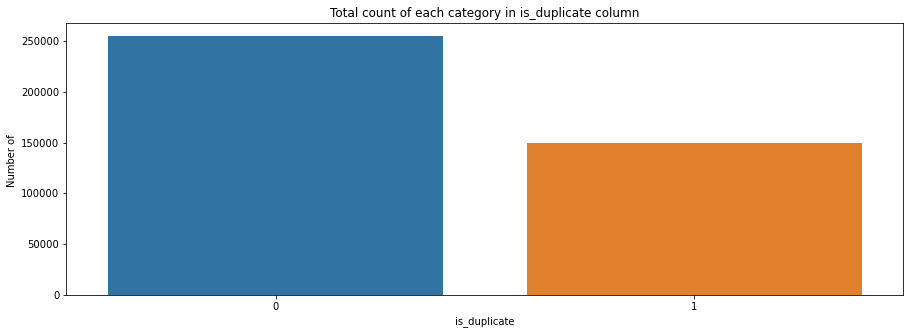

In [10]:
print(pd.value_counts(df['is_duplicate'], sort=True, ascending=False))
CountPlot(df,'is_duplicate')

### Common words in each label (0,1)

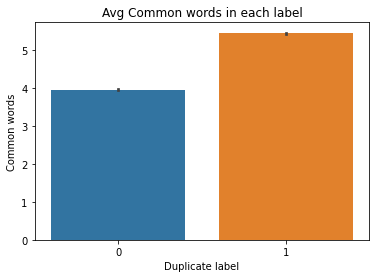

In [11]:
sns.barplot(x = 'is_duplicate', y = 'common_words', data = df)
plt.xlabel("Duplicate label")
plt.ylabel("Common words")
plt.title("Avg Common words in each label")
plt.show()

### Density Plot of common words in each label

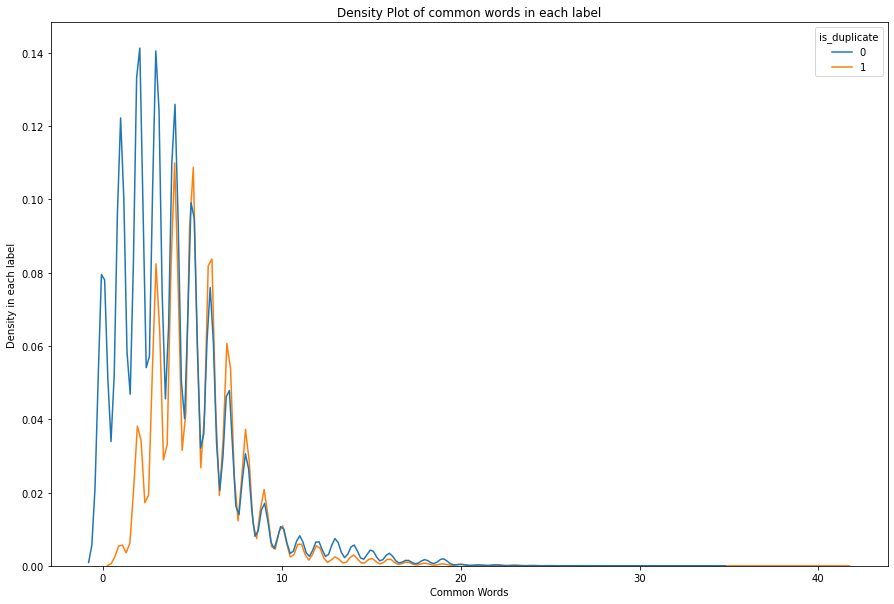

In [12]:
plt.figure(figsize=(15,10))
sns.kdeplot(x= "common_words",
             data=df,
              hue="is_duplicate")
plt.xlabel("Common Words")
plt.ylabel("Density in each label")
plt.title("Density Plot of common words in each label")
plt.show()

### Density Plot of difference in length of each label

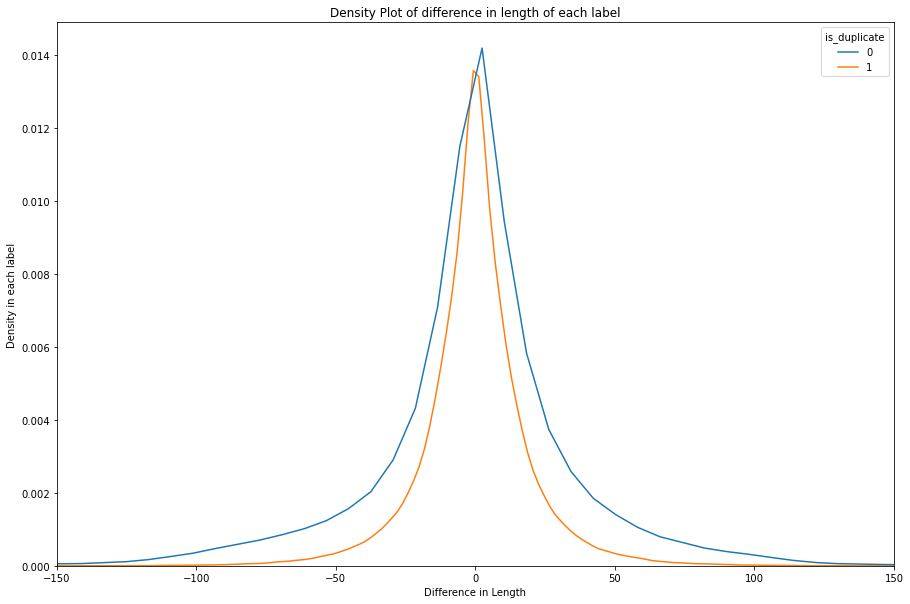

In [13]:
plt.figure(figsize=(15,10))
sns.kdeplot(x= "diff_len",
             data=df,
              hue="is_duplicate")
plt.xlabel("Difference in Length")
plt.ylabel("Density in each label")
plt.title("Density Plot of difference in length of each label")
plt.xlim(-150,150)
plt.show()

### TEXT PRE-PROCESSING

### Creating fuzzy features

In [14]:
def Fuzzy_features(df,a,b):
    df['fuzz_qratio'] = df.apply(lambda x: fuzz.QRatio(str(x[a]), str(x[b])), axis=1)
    df['fuzz_WRatio'] = df.apply(lambda x: fuzz.WRatio(str(x[a]), str(x[b])), axis=1)

    df['fuzz_partial_ratio'] = df.apply(lambda x: fuzz.partial_ratio(str(x[a]), str(x[b])), axis=1)

    df['fuzz_partial_token_set_ratio'] = df.apply(lambda x: fuzz.partial_token_set_ratio(str(x[a]), str(x[b])), axis=1)

    df['fuzz_partial_token_sort_ratio'] = df.apply(lambda x: fuzz.partial_token_sort_ratio(str(x[a]), str(x[b])), axis=1)

    df['fuzz_token_set_ratio'] = df.apply(lambda x: fuzz.token_set_ratio(str(x[a]), str(x[b])), axis=1)
    
    df['fuzz_token_sort_ratio'] = df.apply(lambda x: fuzz.token_sort_ratio(str(x[a]), str(x[b])), axis=1)
    return df

df = Fuzzy_features(df,'question1','question2')
df.head(5)

,question1,question2,is_duplicate,len_q1,len_q2,diff_len,len_char_q1,len_char_q2,len_word_q1,len_word_q2,common_words,fuzz_qratio,fuzz_WRatio,fuzz_partial_ratio,fuzz_partial_token_set_ratio,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,9,20,20,14,14,10,93,95,98,100,89,100,93
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,-37,21,29,8,8,4,66,86,73,100,75,86,63
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,14,25,24,14,14,4,54,63,53,100,71,66,66
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65,-15,19,26,11,11,0,35,35,30,37,38,36,36
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39,37,25,18,13,13,2,46,86,54,100,63,67,47


In [15]:
fs_2 = ['fuzz_qratio', 'fuzz_WRatio', 'fuzz_partial_ratio', 
       'fuzz_partial_token_set_ratio', 'fuzz_partial_token_sort_ratio',
       'fuzz_token_set_ratio', 'fuzz_token_sort_ratio']

### TF-IDF and SVD features

In [16]:
tfv_q1 = TfidfVectorizer(min_df=3,max_features=None,strip_accents='unicode',analyzer='word',token_pattern=r'w{1,}',
                         ngram_range=(1, 2),use_idf=1,smooth_idf=1,sublinear_tf=1,stop_words='english')

tfv_q2 = deepcopy(tfv_q1)

### Removing Null values if any

In [17]:
q1_tfidf = tfv_q1.fit_transform(df['question1'].fillna(""))
q2_tfidf = tfv_q2.fit_transform(df['question2'].fillna(""))

C:\Users\mishr\AppData\Roaming\Python\Python38\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['w'] not in stop_words.
  warnings.warn(


### Applying TruncatedSVD
A TruncatedSVD is an approximate SVD method that can provide you with reliable yet computationally fast SVD matrix decomposition. You can find more hints about how this technique works and it can be applied by consulting this web

In [18]:
svd_q1 = TruncatedSVD(n_components=8)
svd_q2 = TruncatedSVD(n_components=8)

In [19]:
question1_vectors = svd_q1.fit_transform(q1_tfidf)
question2_vectors = svd_q2.fit_transform(q2_tfidf)

### obtain features by stacking the sparse matrices together

In [20]:
fs3_1 = sparse.hstack((q1_tfidf, q2_tfidf))
tfv = TfidfVectorizer(min_df=3, 
                      max_features=None, 
                      strip_accents='unicode', 
                      analyzer='word', 
                      token_pattern=r'w{1,}',
                      ngram_range=(1, 2), 
                      use_idf=1, 
                      smooth_idf=1, 
                      sublinear_tf=1,
                      stop_words='english')

### combine questions and calculate tf-idf

In [21]:
q1q2 = df.question1.fillna("") 
q1q2 += " " + df.question2.fillna("")
fs3_2 = tfv.fit_transform(q1q2)

### obtain features by stacking the matrices together

In [22]:
fs3_3 = np.hstack((question1_vectors, question2_vectors))

### Creating Word2vec model

In [23]:
info_datasets = api.info()
word2vec_model = api.load('word2vec-google-news-300')
info_datasets

{'corpora': {'semeval-2016-2017-task3-subtaskBC': {'num_records': -1,
   'record_format': 'dict',
   'file_size': 6344358,
   'reader_code': 'https://github.com/RaRe-Technologies/gensim-data/releases/download/semeval-2016-2017-task3-subtaskB-eng/__init__.py',
   'license': 'All files released for the task are free for general research use',
   'fields': {'2016-train': ['...'],
    '2016-dev': ['...'],
    '2017-test': ['...'],
    '2016-test': ['...']},
   'description': 'SemEval 2016 / 2017 Task 3 Subtask B and C datasets contain train+development (317 original questions, 3,169 related questions, and 31,690 comments), and test datasets in English. The description of the tasks and the collected data is given in sections 3 and 4.1 of the task paper http://alt.qcri.org/semeval2016/task3/data/uploads/semeval2016-task3-report.pdf linked in section “Papers” of https://github.com/RaRe-Technologies/gensim-data/issues/18.',
   'checksum': '701ea67acd82e75f95e1d8e62fb0ad29',
   'file_name': 'se

### Using NLTK Library

In [24]:
stop_words = set(stopwords.words('english'))

def sent2vec(s, model): 
    M = []
    words = word_tokenize(str(s).lower())
    for word in words:
        #It shouldn't be a stopword
        if word not in stop_words:
            #nor contain numbers
            if word.isalpha():
                #and be part of word2vec
                if word in model:
                    M.append(model[word])
    M = np.array(M)
    if len(M) > 0:
        v = M.sum(axis=0)
        return v / np.sqrt((v ** 2).sum())
    else:
        return np.zeros(300)

In [25]:
w2v_q1 = np.array([sent2vec(q, word2vec_model) for q in df.question1])
w2v_q2 = np.array([sent2vec(q, word2vec_model) for q in df.question2])

In [26]:
df['cosine_distance'] = [cosine(x,y) for (x,y) in zip(w2v_q1, w2v_q2)]
df['cityblock_distance'] = [cityblock(x,y) for (x,y) in zip(w2v_q1, w2v_q2)]
df['jaccard_distance'] = [jaccard(x,y) for (x,y) in zip(w2v_q1, w2v_q2)]
df['canberra_distance'] = [canberra(x,y) for (x,y) in zip(w2v_q1, w2v_q2)]
df['euclidean_distance'] = [euclidean(x,y) for (x,y) in zip(w2v_q1, w2v_q2)]
df['minkowski_distance'] = [minkowski(x,y,3) for (x,y) in zip(w2v_q1, w2v_q2)]
df['braycurtis_distance'] = [braycurtis(x,y) for (x,y) in zip(w2v_q1, w2v_q2)]

C:\ProgramData\Anaconda3\lib\site-packages\scipy\spatial\distance.py:714: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\spatial\distance.py:1172: RuntimeWarning: invalid value encountered in double_scalars
  return l1_diff.sum() / l1_sum.sum()


In [27]:
df.head(5)

,question1,question2,is_duplicate,len_q1,len_q2,diff_len,len_char_q1,len_char_q2,len_word_q1,len_word_q2,...,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio,cosine_distance,cityblock_distance,jaccard_distance,canberra_distance,euclidean_distance,minkowski_distance,braycurtis_distance
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,9,20,20,14,14,...,89,100,93,0.068972,5.081614,1.0,94.023324,0.371408,0.168999,0.186557
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,-37,21,29,8,8,...,75,86,63,0.512164,14.195119,1.0,177.588090,1.012091,0.455910,0.592655
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,14,25,24,14,14,...,71,66,66,0.222009,9.055989,1.0,135.988707,0.666346,0.307828,0.342306
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65,-15,19,26,11,11,...,38,36,36,0.650411,15.987437,1.0,192.237828,1.140536,0.506028,0.692421
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39,37,25,18,13,13,...,63,67,47,0.369993,12.103178,1.0,161.408435,0.860225,0.382770,0.480633


In [28]:
fs4_1 = ['cosine_distance', 'cityblock_distance', 
         'jaccard_distance', 'canberra_distance', 
         'euclidean_distance', 'minkowski_distance',
         'braycurtis_distance']

### Word2vec matrices for the two questions are instead horizontally stacked and stored away in the w2v variable for later usage

In [29]:
w2v = np.hstack((w2v_q1, w2v_q2))

###  Word Mover’s Distance function
Word Mover’s Distance is implemented using a function that returns the distance between two questions, after having transformed them into lowercase and after removing any stopwords

In [30]:
def wmd(s1, s2, model):
    s1 = str(s1).lower().split()
    s2 = str(s2).lower().split()
    stop_words = stopwords.words('english')
    s1 = [w for w in s1 if w not in stop_words]
    s2 = [w for w in s2 if w not in stop_words]
    return model.wmdistance(s1, s2)

In [31]:
df['wmd'] = df.apply(lambda x: wmd(x['question1'], x['question2'], word2vec_model), axis=1)

In [32]:
word2vec_model.fill_norms() 
df['norm_wmd'] = df.apply(lambda x: wmd(x['question1'], x['question2'], word2vec_model), axis=1)
fs4_2 = ['wmd', 'norm_wmd']

In [33]:
scaler = StandardScaler()
y = df.is_duplicate.values
y = y.astype('float32').reshape(-1, 1)
X = df[fs_1+fs_2+fs4_1+fs4_2]
X = X.replace([np.inf, -np.inf], np.nan).fillna(0).values
X = scaler.fit_transform(X)
X = np.hstack((X, fs3_3))
np.random.seed(42)
n_all, _ = y.shape
idx = np.arange(n_all)
np.random.shuffle(idx)
n_split = n_all // 10
idx_val = idx[:n_split]
idx_train = idx[n_split:]
x_train = X[idx_train]
y_train = np.ravel(y[idx_train])
x_val = X[idx_val]
y_val = np.ravel(y[idx_val])
logres = linear_model.LogisticRegression(C=0.1, solver='sag', max_iter=1000)
logres.fit(x_train, y_train)
lr_preds = logres.predict(x_val)
log_res_accuracy = np.sum(lr_preds == y_val) / len(y_val)
print("Logistic regr accuracy: %0.3f" % log_res_accuracy)
params = dict()
params['objective'] = 'binary:logistic'
params['eval_metric'] = ['logloss', 'error']
params['eta'] = 0.02
params['max_depth'] = 4
d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_val, label=y_val)
watchlist = [(d_train, 'train'), (d_valid, 'valid')]
bst = xgb.train(params, d_train, 5000, watchlist, early_stopping_rounds=50, verbose_eval=100)
xgb_preds = (bst.predict(d_valid) >= 0.5).astype(int)
xgb_accuracy = np.sum(xgb_preds == y_val) / len(y_val)
print("Xgb accuracy: %0.3f" % xgb_accuracy)

Logistic regr accuracy: 0.678
[0]	train-logloss:0.68767	train-error:0.30417	valid-logloss:0.68772	valid-error:0.30466
[100]	train-logloss:0.51448	train-error:0.27903	valid-logloss:0.51624	valid-error:0.28126
[200]	train-logloss:0.49308	train-error:0.27533	valid-logloss:0.49553	valid-error:0.27686
[300]	train-logloss:0.48531	train-error:0.27155	valid-logloss:0.48822	valid-error:0.27324
[400]	train-logloss:0.47951	train-error:0.26654	valid-logloss:0.48294	valid-error:0.26902
[500]	train-logloss:0.47597	train-error:0.26375	valid-logloss:0.47974	valid-error:0.26597
[600]	train-logloss:0.47252	train-error:0.26094	valid-logloss:0.47664	valid-error:0.26387
[700]	train-logloss:0.46977	train-error:0.25877	valid-logloss:0.47431	valid-error:0.26179
[800]	train-logloss:0.46736	train-error:0.25672	valid-logloss:0.47225	valid-error:0.26063
[900]	train-logloss:0.46521	train-error:0.25533	valid-logloss:0.47046	valid-error:0.25858
[1000]	train-logloss:0.46321	train-error:0.25371	valid-logloss:0.46885	v

In [55]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
model = XGBClassifier()
eval_set = [(x_train, y_train), (x_val, y_val)]
model.fit(x_train, y_train, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=False)
    
    # make predictions for test data
y_pred = model.predict(x_val)
predictions = [round(value) for value in y_pred]
    
    # evaluate predictions
accuracy = accuracy_score(y_val, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 75.48%


In [64]:
results = model.predict(x_val)

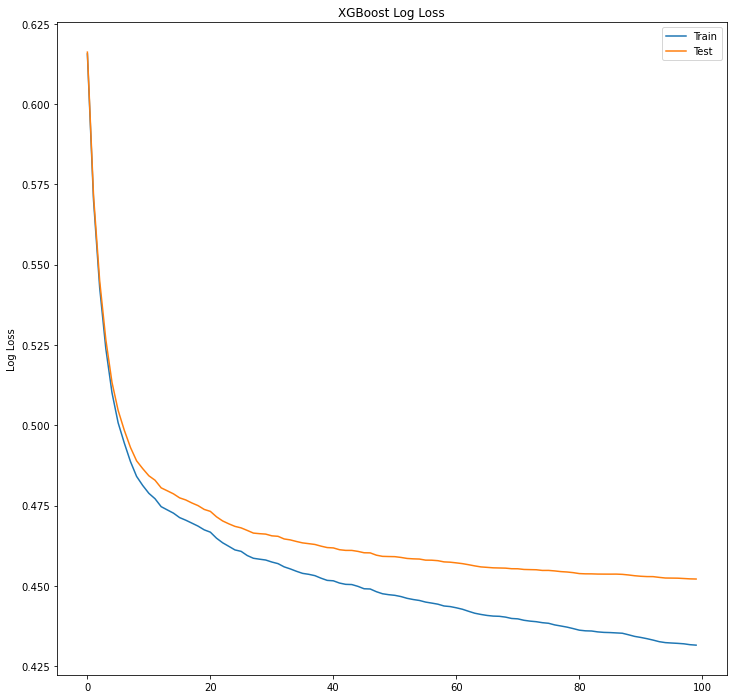

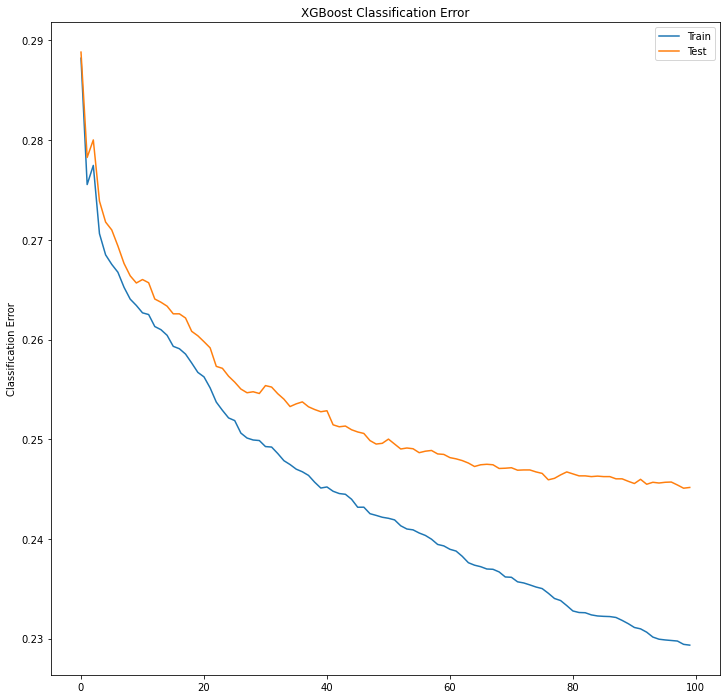

In [65]:
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
    
    # plot log loss
fig, ax = plt.subplots(figsize=(12,12))
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
    
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()
    
    
    # plot classification error
fig, ax = plt.subplots(figsize=(12,12))
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
    
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

### Confusion Matrix

In [35]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_val, lr_preds)

array([[19139,  6358],
       [ 6650,  8282]], dtype=int64)

### Number of occurrences of each question

In [36]:
def Transformation(df):
    df['diff_len'] = LengthDiff(df,'question1','question2')
    df = CharLengthDiff(df,'question1','question2')
    df = WordLengthDiff(df,'question1','question2')
    df = CommonWord(df,'question1','question2')
    df = Fuzzy_features(df,'question1','question2')
    tfv_q1 = TfidfVectorizer(min_df=3,max_features=None,strip_accents='unicode',analyzer='word',token_pattern=r'w{1,}',
                         ngram_range=(1, 2),use_idf=1,smooth_idf=1,sublinear_tf=1,stop_words='english')

    tfv_q2 = deepcopy(tfv_q1)
    q1_tfidf = tfv_q1.fit_transform(df['question1'].fillna(""))
    q2_tfidf = tfv_q2.fit_transform(df['question2'].fillna(""))
    svd_q1 = TruncatedSVD(n_components=8)
    svd_q2 = TruncatedSVD(n_components=8)
    question1_vectors = svd_q1.fit_transform(q1_tfidf)
    question2_vectors = svd_q2.fit_transform(q2_tfidf)
    fs3_1 = sparse.hstack((q1_tfidf, q2_tfidf))
    tfv = TfidfVectorizer(min_df=3, 
                          max_features=None, 
                          strip_accents='unicode', 
                          analyzer='word', 
                          token_pattern=r'w{1,}',
                          ngram_range=(1, 2), 
                          use_idf=1, 
                          smooth_idf=1, 
                          sublinear_tf=1,
                          stop_words='english')
    q1q2 = df.question1.fillna("") 
    q1q2 += " " + df.question2.fillna("")
    fs3_2 = tfv.fit_transform(q1q2)
    fs3_3 = np.hstack((question1_vectors, question2_vectors))
    w2v_q1 = np.array([sent2vec(q, word2vec_model) for q in df.question1])
    w2v_q2 = np.array([sent2vec(q, word2vec_model) for q in df.question2])
    df['cosine_distance'] = [cosine(x,y) for (x,y) in zip(w2v_q1, w2v_q2)]
    df['cityblock_distance'] = [cityblock(x,y) for (x,y) in zip(w2v_q1, w2v_q2)]
    df['jaccard_distance'] = [jaccard(x,y) for (x,y) in zip(w2v_q1, w2v_q2)]
    df['canberra_distance'] = [canberra(x,y) for (x,y) in zip(w2v_q1, w2v_q2)]
    df['euclidean_distance'] = [euclidean(x,y) for (x,y) in zip(w2v_q1, w2v_q2)]
    df['minkowski_distance'] = [minkowski(x,y,3) for (x,y) in zip(w2v_q1, w2v_q2)]
    df['braycurtis_distance'] = [braycurtis(x,y) for (x,y) in zip(w2v_q1, w2v_q2)]
    w2v = np.hstack((w2v_q1, w2v_q2))
    df['wmd'] = df.apply(lambda x: wmd(x['question1'], x['question2'], word2vec_model), axis=1)
    word2vec_model.fill_norms() 
    df['norm_wmd'] = df.apply(lambda x: wmd(x['question1'], x['question2'], word2vec_model), axis=1)
    fs4_2 = ['wmd', 'norm_wmd']
    scaler = StandardScaler()
    X = df[fs_1+fs_2+fs4_1+fs4_2]
    X = X.replace([np.inf, -np.inf], np.nan).fillna(0).values
    X = scaler.fit_transform(X)
    X = np.hstack((X, fs3_3))
    return X

In [37]:
df_test = pd.read_csv('test.csv')
test_id = df_test[['test_id']]
df_test = df_test.drop(['test_id'], axis=1)
df_test.head(5)

,question1,question2
0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,What but is the best way to send money from Ch...,What you send money to China?
3,Which food not emulsifiers?,What foods fibre?
4,"How ""aberystwyth"" start reading?",How their can I start reading?


In [38]:
X_test= Transformation(df_test)

C:\Users\mishr\AppData\Roaming\Python\Python38\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['w'] not in stop_words.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\scipy\spatial\distance.py:714: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\spatial\distance.py:1172: RuntimeWarning: invalid value encountered in double_scalars
  return l1_diff.sum() / l1_sum.sum()


In [39]:
logres_final = linear_model.LogisticRegression(C=0.1, solver='sag', max_iter=1000)
logres_final.fit(X, np.ravel(y))
lr_preds_final = logres.predict(X_test)

In [40]:
test_id['is_duplicate'] = list(lr_preds_final)
test_id['is_duplicate'] = test_id['is_duplicate'].apply(lambda x: int(x))
test_id.to_csv('Submissions.csv')
test_id.head(5)

,test_id,is_duplicate
0,0,0
1,1,1
2,2,1
3,3,0
4,4,1


### words having the highest TFIDF score

In [41]:
df['merge_questions'] = df['question1'] + ' ' + df['question1']
df.head(5)

,question1,question2,is_duplicate,len_q1,len_q2,diff_len,len_char_q1,len_char_q2,len_word_q1,len_word_q2,...,cosine_distance,cityblock_distance,jaccard_distance,canberra_distance,euclidean_distance,minkowski_distance,braycurtis_distance,wmd,norm_wmd,merge_questions
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,9,20,20,14,14,...,0.068972,5.081614,1.0,94.023324,0.371408,0.168999,0.186557,0.217555,0.217555,What is the step by step guide to invest in sh...
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,-37,21,29,8,8,...,0.512164,14.195119,1.0,177.588090,1.012091,0.455910,0.592655,1.368796,1.368796,What is the story of Kohinoor (Koh-i-Noor) Dia...
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,14,25,24,14,14,...,0.222009,9.055989,1.0,135.988707,0.666346,0.307828,0.342306,0.639209,0.639209,How can I increase the speed of my internet co...
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65,-15,19,26,11,11,...,0.650411,15.987437,1.0,192.237828,1.140536,0.506028,0.692421,1.263720,1.263720,Why am I mentally very lonely? How can I solve...
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39,37,25,18,13,13,...,0.369993,12.103178,1.0,161.408435,0.860225,0.382770,0.480633,1.240908,1.240908,"Which one dissolve in water quikly sugar, salt..."


In [42]:
import re

def pre_process(text):
    try:
    
        # lowercase
        text=text.lower()

        #remove tags
        text=re.sub("","",text)

        # remove special characters and digits
        text=re.sub("(\\d|\\W)+"," ",text)
        return text
    except:
        return ''

In [43]:
fs3_2

<404290x10 sparse matrix of type '<class 'numpy.float64'>'
	with 756475 stored elements in Compressed Sparse Row format>

In [44]:
df['merge_questions'] = df['merge_questions'].apply(lambda x:pre_process(x))
df['merge_questions']

0         what is the step by step guide to invest in sh...
1         what is the story of kohinoor koh i noor diamo...
2         how can i increase the speed of my internet co...
3         why am i mentally very lonely how can i solve ...
4         which one dissolve in water quikly sugar salt ...
                                ...                        
404285    how many keywords are there in the racket prog...
404286    do you believe there is life after death do yo...
404287                   what is one coin what is one coin 
404288    what is the approx annual cost of living while...
404289    what is like to have sex with cousin what is l...
Name: merge_questions, Length: 404290, dtype: object

### As dataset is too large, using subset

In [45]:
from sklearn.feature_extraction.text import CountVectorizer
docs=df['merge_questions'].tolist()
docs = docs[:100000]
vectorizer = CountVectorizer(stop_words='english')
  
vectorizer.fit(docs)
  
# Printing the identified Unique words along with their indices
print("Vocabulary: ", vectorizer.vocabulary_)
  
# Encode the Document
vector = vectorizer.transform(docs)

Vocabulary:  {'step': 28967, 'guide': 12931, 'invest': 15446, 'share': 27344, 'market': 18366, 'india': 14812, 'story': 29099, 'kohinoor': 16662, 'koh': 16661, 'noor': 20721, 'diamond': 8317, 'increase': 14772, 'speed': 28528, 'internet': 15303, 'connection': 6362, 'using': 32236, 'vpn': 32940, 'mentally': 18834, 'lonely': 17692, 'solve': 28279, 'dissolve': 8709, 'water': 33143, 'quikly': 24457, 'sugar': 29445, 'salt': 26458, 'methane': 18957, 'carbon': 4571, 'di': 8284, 'oxide': 21733, 'astrology': 1995, 'capricorn': 4544, 'sun': 29503, 'cap': 4512, 'moon': 19598, 'rising': 25917, 'does': 8859, 'say': 26657, 'buy': 4268, 'tiago': 30671, 'good': 12553, 'geologist': 12244, 'use': 32219, 'instead': 15163, 'motorola': 19703, 'company': 6073, 'hack': 13052, 'charter': 5092, 'motorolla': 19704, 'dcx': 7582, 'method': 18961, 'separation': 27132, 'slits': 28018, 'fresnel': 11745, 'biprism': 3318, 'read': 24849, 'youtube': 33995, 'comments': 6010, 'make': 18113, 'physics': 22722, 'easy': 9413,

### Top 5 words with highest TDIF socre

        Words  Count
8259       슬마  34263
24593  북쪽앟관자키  34262
26504      鴻日  34261
12305      高铁  34260
25505      骂人  34259


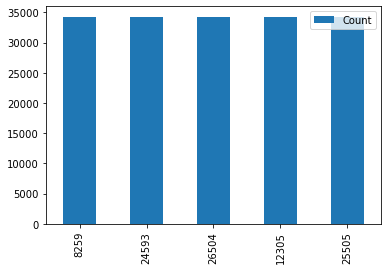

In [48]:
CV = pd.DataFrame(vectorizer.vocabulary_.items(), columns=['Words', 'Count'])
CV = CV.sort_values(by=['Count'], ascending=False)
print(CV.head(5))
CV[:5].plot.bar()
plt.show()

In [66]:
tf = pd.DataFrame(vector.toarray(), columns=vectorizer.get_feature_names())
print(tf.head(5))

C:\Users\mishr\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


   __  ___  _____  ______  __gco  __gh  __main__  __name__  _h_a_t  a_i  ...  \
0   0    0      0       0      0     0         0         0       0    0  ...   
1   0    0      0       0      0     0         0         0       0    0  ...   
2   0    0      0       0      0     0         0         0       0    0  ...   
3   0    0      0       0      0     0         0         0       0    0  ...   
4   0    0      0       0      0     0         0         0       0    0  ...   

   釣魚島  隐忍  雅晶  雅静  飛簷走壁  骂人  高铁  鴻日  북쪽앟관자키  슬마  
0    0   0   0   0     0   0   0   0       0   0  
1    0   0   0   0     0   0   0   0       0   0  
2    0   0   0   0     0   0   0   0       0   0  
3    0   0   0   0     0   0   0   0       0   0  
4    0   0   0   0     0   0   0   0       0   0  

[5 rows x 34264 columns]
